# Assignment 1

In this assignment we will cover Image Stitching and RANSAC. You are expected to complete all workings within the workbook. Use of AI tools is strictly prohibited. 

# Part 1: Image Stitching

## Objective:
Robotic vision systems frequently need to construct panorama images by stitching multiple images together. However, real-world scenarios introduce several challenges such as camera distortion, specular reflections, parallax errors, and inconsistent lighting (varying exposures).

## Task:
You have been provided with 3 sets of image pairs. For each pair, perform image stitching. Each pair will require novel approaches to achieve the highest accuracy. Using methods introduced in the lecture content, and optionally methods you have researched yourself, design an image stitching pipeline for each pair to achieve optimal results.

## Requirements:
1. **Design and Implementation**:
   - Design an image stitching pipeline for each pair of images.
   - Justify each design choice in your pipeline, explaining why you made the decision and showing the practical implications of this design choice.

2. **Documentation**:
   - Even if you fail to perform an accurate stitch, document the design choices you attempted and the appropriate reasoning. This documentation will carry a higher weighting in the marking process.
   - Demonstrate critical thinking and problem-solving in your report.

3. **Visualization**:
   - Visualize the results with visual comparisons (before/after stitching).

4. **Evaluation**:
   - Quantitatively evaluate the stitching quality (e.g., reprojection error, if applicable).
   - Discuss challenges and potential improvements when you try to get a better result.

## Marking Criteria:
- Accuracy and effectiveness of the image stitching pipeline.
- Justification and documentation of design choices.
- Visualization and quantitative evaluation of results.
- Demonstration of critical thinking and problem-solving skills.

Good luck, and remember to document your process thoroughly!

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Stitcher:
    def __init__(self):
        pass
    
    def stitch(self, imgs, detector="SIFT", blending_mode="linearBlending", ratio=0.75, SIFT_thresh=0.04):
        '''
            The main method to stitch image
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
#         print("Left img size (", hl, "*", wl, ")")
#         print("Right img size (", hr, "*", wr, ")")
        
        if detector == "ORB":
            orb = True
            harris = False
        elif detector == "HARRIS":
            orb = False
            harris = True
        else:
            orb = False
            harris = False
        
        # Step1 - extract the keypoints and features by SIFT detector and descriptor
#         print(f"Step1 - Extract the keypoints and features by {detector} detector and SIFT descriptor...")
        kps_l, features_l = self.detectAndDescribe(img_left, harris=harris, ORB=orb, SIFT_thresh=SIFT_thresh)
        kps_r, features_r = self.detectAndDescribe(img_right, harris=harris, ORB=orb, SIFT_thresh=SIFT_thresh)
        

        # Step2 - extract the match point with threshold (David Lowe’s ratio test)
#         print("Step2 - Extract the match point with threshold (David Lowe’s ratio test)...")
        matches_pos = self.matchKeyPoint(features_l, features_r, ratio, ORB=orb)
#         print("The number of matching points:", len(matches_pos))
        
        # Step2 - draw the img with matching point and their connection line
        self.drawMatches([img_left, img_right], [kps_l, kps_r], matches_pos)
        
        # Step3 - fit the homography model with RANSAC algorithm
#         print("Step3 - Fit the best homography model with RANSAC algorithm...")
        HomoMat, mask, inliers = self.find_homography(kps_l, kps_r, matches_pos)
        inliers = np.sum(mask)
        
#         print("Computing errors")
        error = self.compute_reprojection_error(matches=matches_pos,
                                                keypoints1=kps_l,
                                                keypoints2=kps_r,
                                                H=HomoMat)
#         print(f"Reprojection Error: {error}")
        # Step4 - Warp image to create panoramic image
#         print("Step4 - Warp image to create panoramic image...")
        warp_img = self.warp([img_left, img_right], HomoMat, blending_mode) 
        
        return HomoMat, warp_img, inliers
    
    def detect_harris_corners(self, image, block_size=2, ksize=3, k=0.04, threshold=0.05):
        """
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        harris_response = cv2.cornerHarris(gray, block_size, ksize, k)

        # 提取強角點
        keypoints = np.argwhere(harris_response > threshold * harris_response.max())
        keypoints = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in keypoints]

        return keypoints
    
    def detectAndDescribe(self, img, harris=False, ORB=False, SIFT_thresh=0.04):
        '''
        The Detector and Descriptor
        '''
        # SIFT detector and descriptor
        if ORB:
            # create ORB operation
            orb = cv2.ORB_create()
            kps, features = orb.detectAndCompute(img, None)

        elif harris:
            sift = cv2.SIFT_create()
            keypoints = self.detect_harris_corners(img)
            kps, features = sift.compute(img, keypoints)
        else:
            sift = cv2.SIFT_create(contrastThreshold=SIFT_thresh)
            kps, features = sift.detectAndCompute(img, None)
        return kps, features
    
    def matchKeyPoint(self, features_1, features_2, ratio=0.75, ORB=False):
        # Use FLANN to conduct KNN match（k=2, Best match and second match）
        # Using FLANN is for speed, if use brutal force it would cost too much time.
        if ORB:
            index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
        else:
            index_params = dict(algorithm=1, trees=5)  # Using KD-Tree
        search_params = dict(checks=50)  # check counting

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(features_1, features_2, k=2)
        # Conducting Nearest Neighbor Ratio Test
        good_matches = []
        
        # Best match for m, second for n
        for item in matches:
            if isinstance(item, tuple) and len(item) == 2:
                m, n = item
                if m.distance < ratio * n.distance:
                    good_matches.append(m)
        return good_matches
    
    def find_homography(self, kps_left, kps_right, good_matches):
        if len(good_matches) > 4:
            src_pts = np.float32([kps_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kps_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            # Computing homography and Dealing with outliers: RANSAC
            H, mask = cv2.findHomography(srcPoints=src_pts,
                                         dstPoints=dst_pts,
                                         method=cv2.RANSAC,
                                         ransacReprojThreshold=5.0,
                                         maxIters=8000)
            inliers = np.sum(mask)
            return H, mask, inliers
        else:
            inliers = 0
            return None, None
        
    def compute_reprojection_error(self, matches, keypoints1, keypoints2, H):
        """計算重投影誤差"""
        total_error = 0
        num_points = len(matches)
        for match in matches:
            pt1 = np.array(keypoints1[match.queryIdx].pt + (1,))  # (x, y, 1)
            pt2 = np.array(keypoints2[match.trainIdx].pt)  # (x', y')
            # 透過 Homography 變換 pt1
            projected_pt = H @ pt1
            projected_pt /= projected_pt[2]  # 轉換成 2D 點
            projected_pt = projected_pt[:2]  # 取 (x', y')

            # 計算歐幾里得距離
            error = np.linalg.norm(projected_pt - pt2)
            total_error += error

        return total_error / num_points if num_points > 0 else float('inf')
        
    def drawMatches(self, imgs, keypoints, matches_pos):
        # 畫出匹配結果
        img_left = imgs[0]
        img_right = imgs[1]
        keypoints_left = keypoints[0]
        keypoints_right = keypoints[1]
        img_matches = cv2.drawMatches(img_left, keypoints_left,
                                      img_right, keypoints_right, 
                                      matches_pos[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # return the visualization
        plt.figure(4)
        plt.title("img with matching points")
        plt.imshow(img_matches[:, :, ::-1])
        
    def removeBlackBorder(self, img):
        '''
        Remove img's the black border 
        '''
        h, w = img.shape[:2]
        reduced_h, reduced_w = h, w
        # right to left
        for col in range(w - 1, -1, -1):
            all_black = True
            for i in range(h):
                if (np.count_nonzero(img[i, col]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_w = reduced_w - 1
                
        # bottom to top 
        for row in range(h - 1, -1, -1):
            all_black = True
            for i in range(reduced_w):
                if (np.count_nonzero(img[row, i]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_h = reduced_h - 1
        
        return img[:reduced_h, :reduced_w]
        
    def warp(self, imgs, HomoMat, blending_mode):
        '''
           Warp image to create panoramic image
           There are three different blending method - noBlending、linearBlending、linearBlendingWithConstant
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        stitch_img = np.zeros( (max(hl, hr), wl + wr, 3), dtype="int") # create the (stitch)big image accroding the imgs height and width 
        
        if (blending_mode == "noBlending"):
            stitch_img[:hl, :wl] = img_left
            
        # Transform Right image(the coordination of right image) to destination iamge(the coordination of left image) with HomoMat
        for i in range(stitch_img.shape[0]):
            for j in range(stitch_img.shape[1]):
                coor = np.array([j, i, 1])
                img_right_coor = HomoMat @ coor # the coordination of right image
                img_right_coor /= img_right_coor[2]
                
                # you can try like nearest neighbors or interpolation  
                y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1])) # y for width, x for height
                
                
                # if the computed coordination not in the (hegiht, width) of right image, it's not need to be process 
                if (x < 0 or x >= hr or y < 0 or y >= wr):
                    continue
                # else we need the tranform for this pixel
                stitch_img[i, j] = img_right[x, y]
            
        
        # create the Blender object to blending the image
        blender = Blender()
        if (blending_mode == "linearBlending"):
            stitch_img = blender.linearBlending([img_left, stitch_img])
        elif (blending_mode == "linearBlendingWithConstant"):
            stitch_img = blender.linearBlendingWithConstantWidth([img_left, stitch_img])
        
        # remove the black border
        stitch_img = self.removeBlackBorder(stitch_img)
        
        return stitch_img

In [31]:
class Blender:
    def linearBlending(self, imgs):
        '''
        linear Blending(also known as Feathering)
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        
        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
#         left_mask = img_left_mask * 255
#         cv2.imwrite('results/left_masked.png', left_mask)
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1
#         right_mask = img_right_mask * 255
#         cv2.imwrite('results/right_masked.png', right_mask)

        
        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if j <= int((wr-1)//2):
                    if (np.count_nonzero(img_right_mask[i, j]) > 0):
                        overlap_mask[i, j] = 1
                # else:
                #     if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                #         overlap_mask[i, j] = 1

        # Plot the overlap mask
        plt.figure(21)
        plt.title("overlap_mask")
        plt.imshow(overlap_mask.astype(int), cmap="gray")
        
        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr): 
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j
            
            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            for j in range(minIdx, maxIdx + 1):
                alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
        
        
        
        linearBlending_img = np.copy(img_right)
        linearBlending_img[:hl, :wl] = np.copy(img_left)
        # linear blending
        for i in range(hr):
            for j in range(wr):
                if ( np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlending_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]
        
        return linearBlending_img

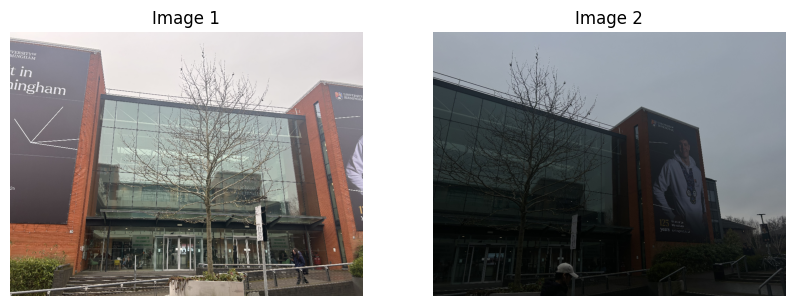

Left img size ( 750 * 1000 )
Right img size ( 750 * 1000 )
Step1 - Extract the keypoints and features by HARRIS detector and SIFT descriptor...
Step2 - Extract the match point with threshold (David Lowe’s ratio test)...
The number of matching points: 170
Step3 - Fit the best homography model with RANSAC algorithm...
Computing errors
Reprojection Error: 284.7711652909852
Step4 - Warp image to create panoramic image...


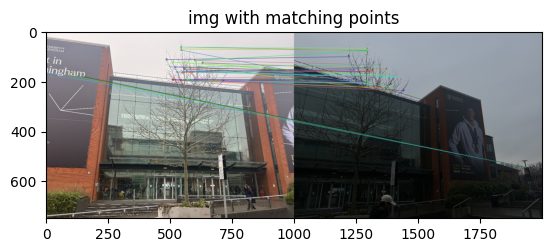

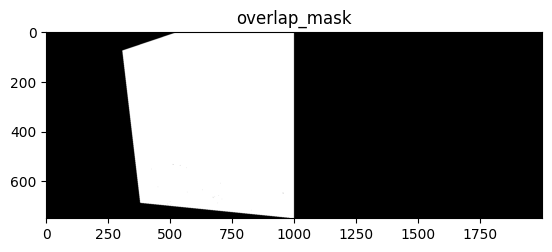

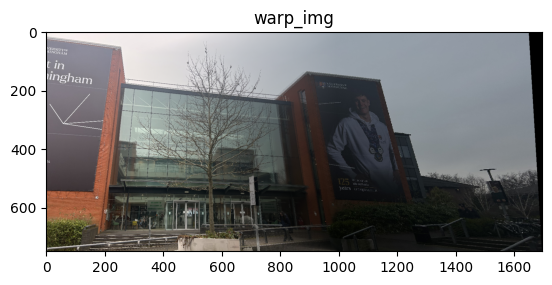

In [22]:
path1 = 'imgs/part1/stiching_1/CS1.jpg'
path2 = 'imgs/part1/stiching_1/CS2.jpg'
img_left = cv2.imread(path1)
img_right = cv2.imread(path2)
img_left = cv2.resize(img_left, (1000, 750))
img_right = cv2.resize(img_right, (1000, 750))


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_left[:, :, ::-1], cmap='gray')
ax[0].set_title("Image 1")
ax[0].axis("off")

ax[1].imshow(img_right[:, :, ::-1], cmap='gray')
ax[1].set_title("Image 2")
ax[1].axis("off")
plt.show()

# The stitch object to stitch the image
blending_mode = "linearBlending" # two mode - noBlending、linearBlending
stitcher = Stitcher()
HomoMat, warp_img, inliers = stitcher.stitch([img_left, img_right], 
                                                detector="HARRIS",
                                                blending_mode=blending_mode
                                                )
# plot the stitched image
plt.figure(14)
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))

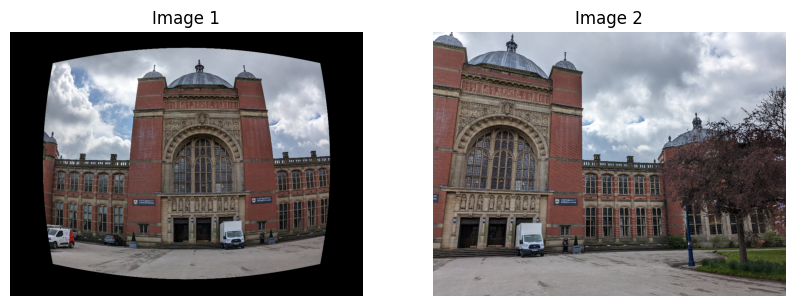

Left img size ( 750 * 1000 )
Right img size ( 750 * 1000 )
Step1 - Extract the keypoints and features by SIFT detector and SIFT descriptor...
Step2 - Extract the match point with threshold (David Lowe’s ratio test)...
The number of matching points: 791
Step3 - Fit the best homography model with RANSAC algorithm...
Computing errors
Reprojection Error: 48.282219557220884
Step4 - Warp image to create panoramic image...


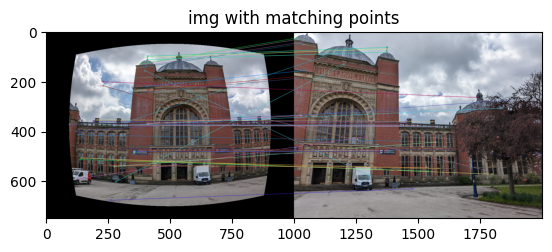

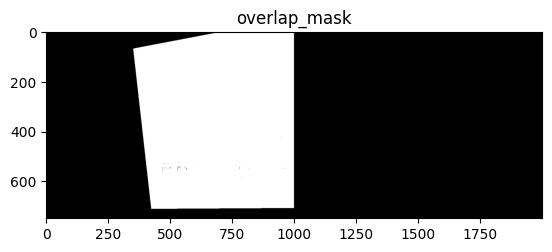

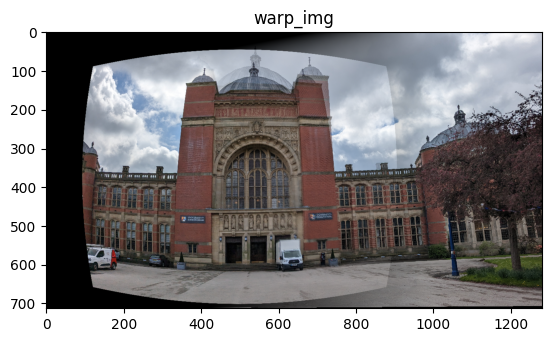

In [23]:
path1 = 'imgs/part1/stiching_2/UOB1.jpg'
path2 = 'imgs/part1/stiching_2/UOB2.jpg'
img_left = cv2.imread(path1)
img_right = cv2.imread(path2)
img_left = cv2.resize(img_left, (1000, 750))
img_right = cv2.resize(img_right, (1000, 750))


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_left[:, :, ::-1], cmap='gray')
ax[0].set_title("Image 1")
ax[0].axis("off")

ax[1].imshow(img_right[:, :, ::-1], cmap='gray')
ax[1].set_title("Image 2")
ax[1].axis("off")
plt.show()

# The stitch object to stitch the image
blending_mode = "linearBlending" # two mode - noBlending、linearBlending
stitcher = Stitcher()
HomoMat, warp_img, inliers = stitcher.stitch([img_left, img_right], 
                                                detector="SIFT",
                                                blending_mode=blending_mode
                                                )
# plot the stitched image
plt.figure(14)
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))

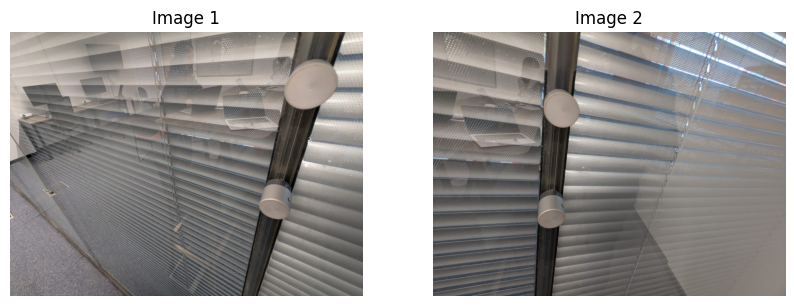

Left img size ( 750 * 1000 )
Right img size ( 750 * 1000 )
Step1 - Extract the keypoints and features by ORB detector and SIFT descriptor...
Step2 - Extract the match point with threshold (David Lowe’s ratio test)...
The number of matching points: 34
Step3 - Fit the best homography model with RANSAC algorithm...
Computing errors
Reprojection Error: 385.8568456877906
Step4 - Warp image to create panoramic image...


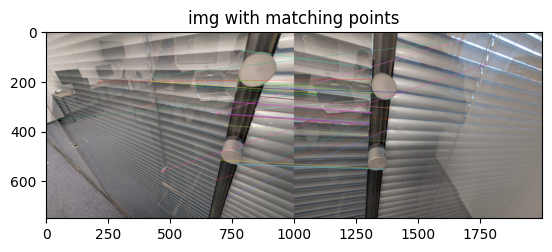

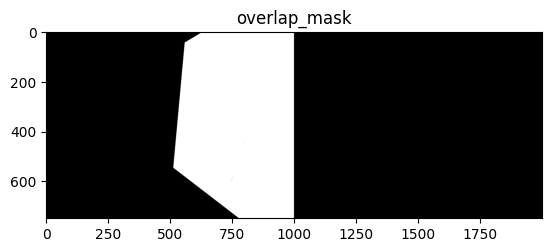

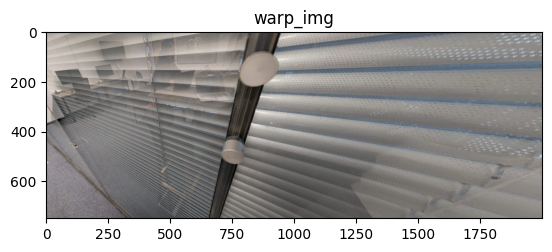

In [24]:
path1 = 'imgs/part1/stiching_3/Door2.jpeg'
path2 = 'imgs/part1/stiching_3/Door1.jpeg'
img_left = cv2.imread(path1)
img_right = cv2.imread(path2)
img_left = cv2.resize(img_left, (1000, 750))
img_right = cv2.resize(img_right, (1000, 750))


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_left[:, :, ::-1], cmap='gray')
ax[0].set_title("Image 1")
ax[0].axis("off")

ax[1].imshow(img_right[:, :, ::-1], cmap='gray')
ax[1].set_title("Image 2")
ax[1].axis("off")
plt.show()

# The stitch object to stitch the image
blending_mode = "linearBlending" # two mode - noBlending、linearBlending
stitcher = Stitcher()
HomoMat, warp_img, inliers = stitcher.stitch([img_left, img_right], 
                                                detector="ORB",
                                                blending_mode=blending_mode
                                                )
# plot the stitched image
plt.figure(14)
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))

## Part 2: RANSAC

In this task, you are required to evaluate how varying the SIFT (Scale-Invariant Feature Transform) threshold affects the performance of the RANSAC (Random Sample Consensus) algorithm.

For different values of the SIFT threshold, execute the RANSAC algorithm by performing the following steps:
- Randomly select a minimal subset of the data points required to fit the model.
- Fit the model to this subset.
- Determine the number of inliers, which are data points that fit the model within a certain error tolerance.
- Repeat the process for a fixed number of iterations.
- Choose the model with the largest number of inliers as the best model.


Your report should include:

- Plots: Include plots to visualize the following:
    The relationship between the SIFT threshold values and the number of inliers detected by RANSAC.
    The fitted model and inliers for at least three different SIFT threshold values. Other figures to support your analysis.

- Analysis: Provide a detailed analysis and discussion on how the variation in the SIFT threshold impacts the robustness and accuracy of the RANSAC algorithm.




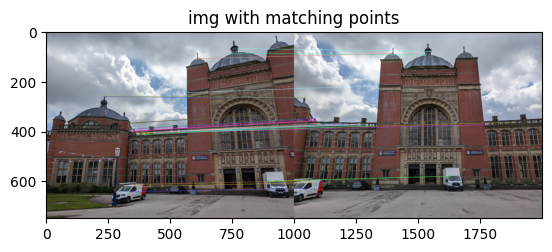

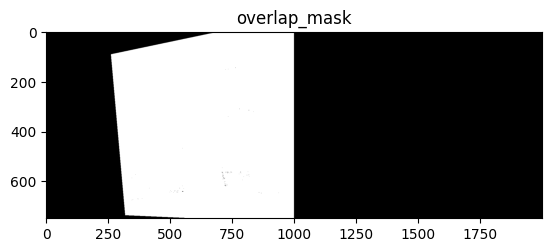

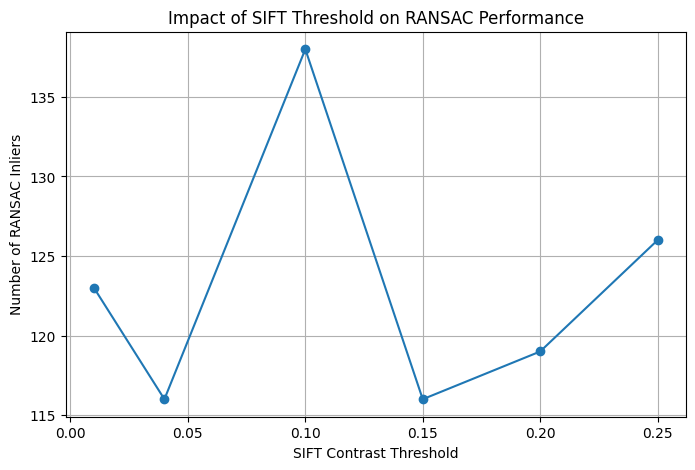

In [33]:
path1 = 'imgs/part2/demo1.jpg'
path2 = 'imgs/part2/demo2.jpg'
img_left = cv2.imread(path1)
img_right = cv2.imread(path2)
img_left = cv2.resize(img_left, (1000, 750))
img_right = cv2.resize(img_right, (1000, 750))

# The stitch object to stitch the image
blending_mode = "linearBlending" # two mode - noBlending、linearBlending
stitcher = Stitcher()
SIFT_thresh = [0.01, 0.04, 0.1, 0.15, 0.2, 0.25]
ransac_inliers = []
for value in SIFT_thresh:
    HomoMat, warp_img, inliers = stitcher.stitch([img_left, img_right], 
                                        detector="ORB",
                                        blending_mode=blending_mode,
                                        SIFT_thresh=value)
    ransac_inliers.append(inliers)
    
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(SIFT_thresh, ransac_inliers, marker='o', linestyle='-')
plt.xlabel('SIFT Contrast Threshold')
plt.ylabel('Number of RANSAC Inliers')
plt.title('Impact of SIFT Threshold on RANSAC Performance')
plt.grid()
plt.show()